In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle
import os
import time

import seaborn as sns
sns.set()
from matplotlib import style
# style.use('ggplot')
%load_ext autoreload
%autoreload 2

# Pure TCN for Time Series Only

In [49]:
train_arrs, test_arrs = [], []

arr_names = ["Xhist", "y", "dateticker"]

for arr_name in arr_names:
    fname = 'data/temporal_data/' + arr_name + "Train.npy"
    train_arrs.append(np.load(fname, allow_pickle=True))
    fname = 'data/temporal_data/' + arr_name + "Test.npy"
    test_arrs.append(np.load(fname, allow_pickle=True))
    
XseqTrain, yTrain, datetickerTrain = train_arrs
XseqTest, yTest, datetickerTest = test_arrs

print(XseqTrain.shape, XseqTest.shape, yTrain.shape, yTest.shape)

(498414, 128) (60412, 128) (498414, 1) (60412, 1)


In [50]:
import torch
from torch.utils.data import DataLoader, TensorDataset
bs = 64
timesteps = 128

# train_ds = SeqDataset(XseqTrain, yTrain, timesteps)
# test_ds = SeqDataset(XseqTest, yTest, timesteps)


x_train = torch.from_numpy(XseqTrain[:, np.newaxis, -timesteps:]).type(torch.Tensor)
x_test = torch.from_numpy(XseqTest[:, np.newaxis, -timesteps:]).type(torch.Tensor)
y_train = torch.from_numpy(yTrain.astype(np.float)).type(torch.Tensor)
y_test = torch.from_numpy(yTest.astype(np.float)).type(torch.Tensor)

train_ds = TensorDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)


train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(test_ds, bs, shuffle=True)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  torch.Size([498414, 1, 128])
y_train.shape =  torch.Size([498414, 1])
x_test.shape =  torch.Size([60412, 1, 128])
y_test.shape =  torch.Size([60412, 1])


In [51]:
# from tcn import *
import tcn

# channels = [16, 16, 16, 16, 16, 16, 16, 1]
channels = [32]*8 + [1]
model = tcn.TemporalConvNet(1, channels)
print(model)

TemporalConvNet(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (chomp1): Chomp1d()
      (relu

In [52]:
# tcn.train_model(model, train_dl, val_dl, n_epochs=5, lr=1e-2)
tcn.train_model(model, train_dl, val_dl, n_epochs=2, lr=1e-3)

100%|██████████| 7788/7788 [02:46<00:00, 46.65it/s]


Epoch 1: training loss=0.02713


  0%|          | 3/7788 [00:00<04:39, 27.89it/s]

Epoch 1: val loss=0.00319


100%|██████████| 7788/7788 [02:44<00:00, 47.36it/s]


Epoch 2: training loss=0.00124
Epoch 2: val loss=0.00106


In [53]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# for xb, yb in tqdm(train_dl):
#     xb, yb = xb.to(device), yb.to(device)
# #     print(xb.shape)
#     preds = model(xb)
#     print(preds.shape)

In [54]:
train_preds, train_targets = tcn.predict(model, train_ds, 1024)
test_preds, test_targets = tcn.predict(model, test_ds, 1024)

100%|██████████| 59/59 [00:01<00:00, 32.98it/s]


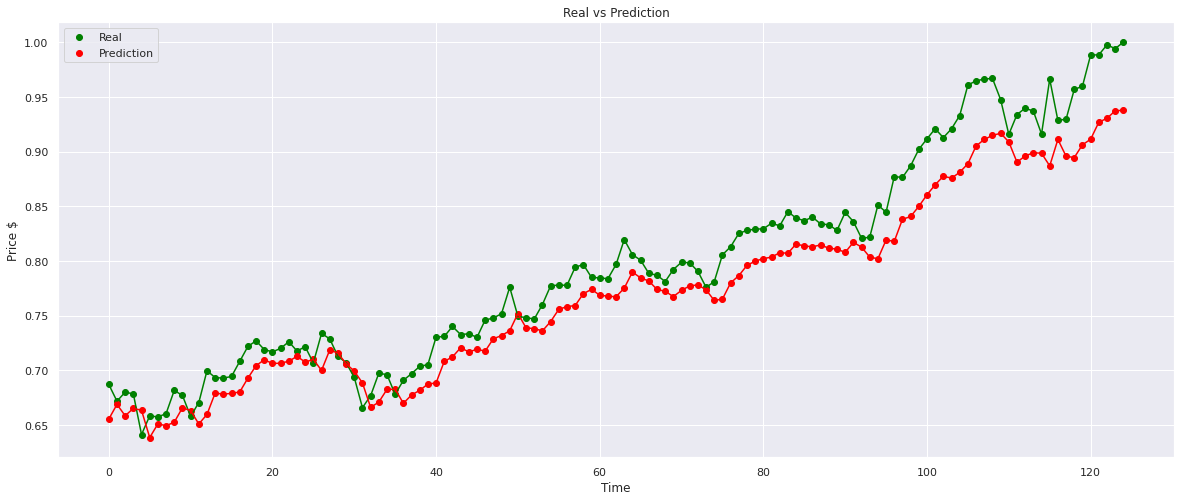

In [59]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['tcn'] = test_preds
# df_pred_test.head()

ticker = 'GOOG'
idx = df_pred_test[df_pred_test.ticker==ticker].index
y_plot_pred = df_pred_test.iloc[idx]['tcn'].values
y_plot_real = df_pred_test.iloc[idx]['target_price'].values

n = len(y_plot_real)
fig, ax = plt.subplots(1,1, figsize=(20,8))
x_plot = np.arange(n)
plt.plot(x_plot, y_plot_real, color="green")
plt.scatter(x_plot, y_plot_real, c="green", label="Real")
plt.plot(x_plot, y_plot_pred, color="red")
plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
plt.title("Real vs Prediction")
plt.xlabel("Time")
plt.ylabel("Price $")
plt.legend()
plt.show()

In [60]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['tcn_pred'] = test_preds

df_pred_test.to_csv('Results/tcn_test_preds.csv', index=False)
df_pred_test.tail()

,Date,ticker,target_price,tcn_pred
60407,2020-02-07,ZTS,0.977593,0.900534
60408,2020-02-10,ZTS,0.991468,0.918852
60409,2020-02-11,ZTS,0.981624,0.929662
60410,2020-02-12,ZTS,1.000000,0.928262
60411,2020-02-13,ZTS,0.992781,0.938188


In [18]:
PATH = './models/ts_tcn.mod'
torch.save(model.state_dict(), PATH)

# Hybrid TCN

In [2]:
df = pd.read_csv('data_scaled.csv')
# df = df.drop(columns=["Return"])
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621391 entries, 0 to 621390
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       621391 non-null  datetime64[ns]
 1   Adj Close                  621391 non-null  float64       
 2   volume_obv                 621391 non-null  float64       
 3   volume_fi                  621391 non-null  float64       
 4   volatility_bbm             621391 non-null  float64       
 5   volatility_bbw             621391 non-null  float64       
 6   volatility_bbhi            621391 non-null  float64       
 7   volatility_bbli            621391 non-null  float64       
 8   trend_macd                 621391 non-null  float64       
 9   trend_macd_signal          621391 non-null  float64       
 10  trend_macd_diff            621391 non-null  float64       
 11  trend_psar_up_indicator    621391 non-null  float64 

In [3]:
# def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'Adj Close', 'Return', 'target_price']):
def cat_cont_split(df, maxcard=55, omit_vars=['Date', 'target_price']):
    """Helper function that returns column names of categorical & continuous features from df."""
    cat_feats, cont_feats = [], []
    for col in df:
        if col in omit_vars: 
            continue
        if (df[col].dtype==int or df[col].dtype==float) and df[col].unique().shape[0] > maxcard:
            cont_feats.append(col)
        else:
            cat_feats.append(col)
    return cat_feats, cont_feats
    
cat_vars, cont_vars = cat_cont_split(df)
print(len(cat_vars), 'Categorical Features:')
print(cat_vars)
print(len(cont_vars), 'Continuous Features:')
print(cont_vars)

18 Categorical Features:
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
12 Continuous Features:
['Adj Close', 'volume_obv', 'volume_fi', 'volatility_bbm', 'volatility_bbw', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'momentum_ao', 'momentum_roc', 'Dayofyear', 'Elapsed']


In [4]:
class Categorifier:
    ''' Transform categorical features into category types '''
    def apply_train(self, df, cat_vars):
        self.cat_vars = cat_vars
        self.categories = {}
        for v in self.cat_vars:
            df.loc[:, v] = df.loc[:, v].astype('category').cat.as_ordered()
            self.categories[v] = df[v].cat.categories
            
    def apply_test(self, df_test):
        for v in self.cat_vars:
            df_test.loc[:, v] = pd.Categorical(df[v], categories=self.categories[v], ordered=True)

cat = Categorifier()
cat.apply_train(df, cat_vars)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621391 entries, 0 to 621390
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Date                       621391 non-null  datetime64[ns]
 1   Adj Close                  621391 non-null  float64       
 2   volume_obv                 621391 non-null  float64       
 3   volume_fi                  621391 non-null  float64       
 4   volatility_bbm             621391 non-null  float64       
 5   volatility_bbw             621391 non-null  float64       
 6   volatility_bbhi            621391 non-null  category      
 7   volatility_bbli            621391 non-null  category      
 8   trend_macd                 621391 non-null  float64       
 9   trend_macd_signal          621391 non-null  float64       
 10  trend_macd_diff            621391 non-null  float64       
 11  trend_psar_up_indicator    621391 non-null  category

In [5]:
dep_var = 'target_price'
cont_vars = cont_vars
cat_sz = [(nc, len(df[nc].cat.categories)+1) for nc in cat_vars]
# emb_szs = [(nc, min(50, (nc+1)//2)) for _, nc in cat_sz]
emb_szs = [(nc, min(51, round(1.6*nc**0.56))) for _, nc in cat_sz]

In [6]:
train_arrs, test_arrs = [], []

arr_names = ["Xhist", "Xcat", "Xcont", "y", "dateticker"]

for arr_name in arr_names:
    fname = 'data/temporal_data/' + arr_name + "Train.npy"
    train_arrs.append(np.load(fname, allow_pickle=True))
    fname = 'data/temporal_data/' + arr_name + "Test.npy"
    test_arrs.append(np.load(fname, allow_pickle=True))
    
XseqTrain, XcatTrain, XcontTrain, yTrain, datetickerTrain = train_arrs
XseqTest, XcatTest, XcontTest, yTest, datetickerTest = test_arrs

print(XseqTrain.shape, XseqTest.shape, yTrain.shape, yTest.shape)

(498414, 128) (60412, 128) (498414, 1) (60412, 1)


In [8]:
import hybrid_tcn
from torch.utils.data import DataLoader

bs = 64
timesteps = 128

train_ds = hybrid_tcn.HybridDataset(XcatTrain, XcontTrain, XseqTrain, yTrain, timesteps)
train_ds = hybrid_tcn.HybridDataset(np.vstack([XcatTrain, XcatTest]), 
                                     np.vstack([XcontTrain, XcontTest]),
                                     np.vstack([XseqTrain, XseqTest]),
                                     np.vstack([yTrain,yTest]), timesteps)

test_ds = hybrid_tcn.HybridDataset(XcatTest, XcontTest, XseqTest, yTest, timesteps)

train_dl = DataLoader(train_ds, bs, shuffle=True)
val_dl = DataLoader(test_ds, 1024, shuffle=True)

In [9]:
model = hybrid_tcn.HybridTCN(emb_szs, len(cont_vars), hidden_sizes=[1024, 512],
                  emb_dropout = 0.1, dropout_prob = [0.001, .01], use_bn=True,
                  cnn_input_size=1, num_kernels=32, kernel_size=2,
                  cnn_num_blocks=7, cnn_output_size=30, cnn_dropout=0.2)
print(model)

HybridTCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(32, 32, kernel_size=(2,), stride=(1

In [10]:
hybrid_tcn.train_model(model, train_dl, val_dl, n_epochs=5, lr=1e-4)

100%|██████████| 8732/8732 [03:22<00:00, 43.19it/s]


Epoch 1: training loss=0.03253


  0%|          | 3/8732 [00:00<04:59, 29.12it/s]

Epoch 1: val loss=0.00265


100%|██████████| 8732/8732 [03:23<00:00, 42.91it/s]


Epoch 2: training loss=0.00689


  0%|          | 3/8732 [00:00<06:03, 24.01it/s]

Epoch 2: val loss=0.00154


100%|██████████| 8732/8732 [03:20<00:00, 43.57it/s]


Epoch 3: training loss=0.00330


  0%|          | 3/8732 [00:00<05:06, 28.52it/s]

Epoch 3: val loss=0.00070


100%|██████████| 8732/8732 [03:23<00:00, 42.92it/s]


Epoch 4: training loss=0.00221


  0%|          | 3/8732 [00:00<05:46, 25.17it/s]

Epoch 4: val loss=0.00102


100%|██████████| 8732/8732 [03:19<00:00, 43.68it/s]


Epoch 5: training loss=0.00185
Epoch 5: val loss=0.00073


In [23]:
hybrid_tcn.train_model(model, val_dl, n_epochs=1, lr=1e-4)

100%|██████████| 59/59 [00:10<00:00,  5.67it/s]

Epoch 1: training loss=0.00106


In [40]:
# train_preds, train_targets = hybrid_tcn.predict(model, train_ds, 512)
test_preds, test_targets = hybrid_tcn.predict(model, test_ds, 512)

100%|██████████| 118/118 [00:02<00:00, 56.33it/s]


In [44]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['cs2v_pred'] = test_preds

df_pred_test.to_csv('Results/tcn_s2v_test_preds.csv', index=False)
df_pred_test.tail()

,Date,ticker,target_price,cs2v_pred
60407,2020-02-07,ZTS,0.977593,0.953009
60408,2020-02-10,ZTS,0.991468,0.980636
60409,2020-02-11,ZTS,0.981624,0.984930
60410,2020-02-12,ZTS,1.000000,0.987786
60411,2020-02-13,ZTS,0.992781,0.990737


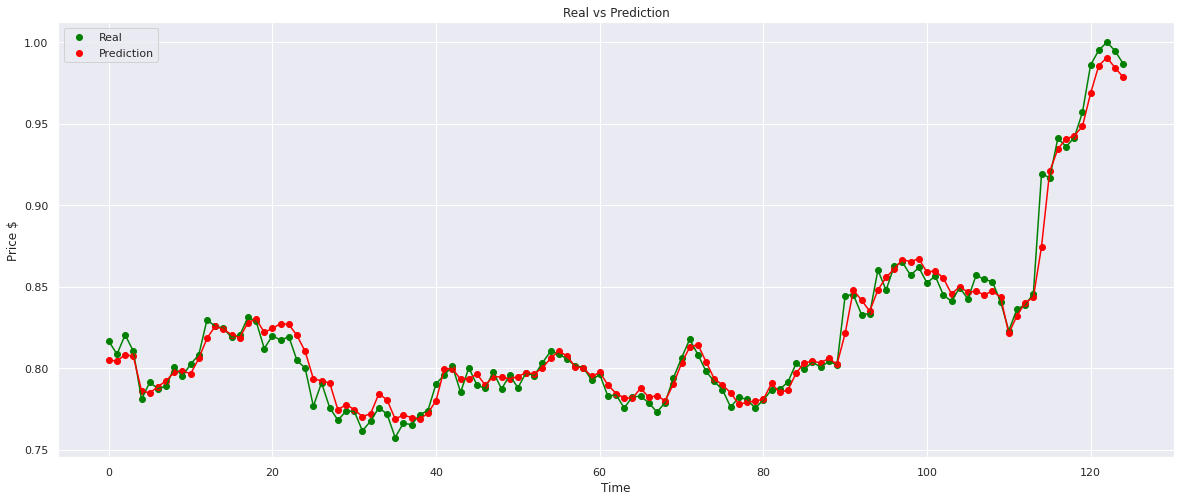

In [45]:
df_pred_test = pd.DataFrame(datetickerTest, columns=['Date', 'ticker'])
df_pred_test['target_price'] = test_targets
df_pred_test['pred'] = test_preds
# df_pred_test.head()

ticker = 'AMZN'
idx = df_pred_test[df_pred_test.ticker==ticker].index
y_plot_pred = df_pred_test.iloc[idx]['pred'].values
y_plot_real = df_pred_test.iloc[idx]['target_price'].values

n = len(y_plot_real)
fig, ax = plt.subplots(1,1, figsize=(20,8))
x_plot = np.arange(n)
plt.plot(x_plot, y_plot_real, color="green")
plt.scatter(x_plot, y_plot_real, c="green", label="Real")
plt.plot(x_plot, y_plot_pred, color="red")
plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
plt.title("Real vs Prediction")
plt.xlabel("Time")
plt.ylabel("Price $")
plt.legend()
plt.show()